In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
%matplotlib notebook
from scipy import *
from tqdm.notebook import *
import sys
import seaborn as sns
sns.set_theme(style="whitegrid")
import time
from numba import jit
from numpy import imag

# Uncomment the next two lines for the cells to print every information
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

# Simulation of the Brownian Motion

### Parameters:

In [13]:
#### system parameters
k = np.array([1.,0.3,.5])

gama = 1.
diff = 1.

# particle param.:
m = 1.
# simulation parameters
N = 2
T = 2**22
print("Simulation time =", T)

delta_t = 0.0001
delta_x = 0.1
delta_v = 0.

time_axis = np.arange(0, T*delta_t, delta_t)

k_b = 1.32 * 10**(-23)

print("Temperature =", gama*diff/k_b)
print("Optical trap characteristic time =", np.max(gama/k[0]))
print("Time interval =", delta_t)
print("Momentum relaxation time =", m/gama)

Simulation time = 4194304
Temperature = 7.575757575757575e+22
Optical trap characteristic time = 1.0
Time interval = 0.0001
Momentum relaxation time = 1.0


### Simulate:

In [14]:
# FDM

data = np.zeros((N,T,3))
from numba import jit

@jit(nopython=True)
def force(r, k, theta=0.):
    x, y, z = r[0], r[1], r[2]
    kx, ky, kz = k[0], k[1], k[2]
    Fx = -1.* (kx*(x*np.cos(theta)-y*np.sin(theta))*np.cos(theta)+(ky*(x*np.sin(theta)+y*np.cos(theta))*np.sin(theta)))
    Fy = -1.* (-1.*kx*(x*np.cos(theta)-y*np.sin(theta))*np.sin(theta)+(ky*(x*np.sin(theta)+y*np.cos(theta))*np.cos(theta)))
    Fz = -1.*kz*z
    return np.array([Fx,Fy,Fz])

@jit(nopython=True)
def func(x1, x0, m, gama, diff, delta_t, force=force):
    F = force(x1, k)
    return np.array([((gama*delta_t/m +2)*x1[axis] +F[axis]*delta_t**2 - x0[axis] + np.sqrt(2*diff*gama*gama)*np.random.normal(0.,1.)*delta_t**(3/2))/(1+ gama*delta_t/m) for axis in range(3)])

@jit(nopython=True)
def run(T, m, gama, diff, delta_t, force=force):
    run = np.zeros((T,3))  # [time, axis]
    F = force(run[0, :], k)
    run[1, :] = np.array([((gama*delta_t/m +2)*run[0, axis] +F[axis]*delta_t**2 + np.sqrt(2*diff*gama*gama)*np.random.normal(0.,1.)*delta_t**(3/2))/(1+ gama*delta_t/m) for axis in range(3)])
    for t in range(2, T):
        run[t, :] = func(run[t-1], run[t-2], m, gama, diff, delta_t, force=force)
    return run
    
for exp in range(N):
    data[exp, :, :] = run(T, m, gama, diff, delta_t, force=force)


# Potential field:

<ipython-input-15-f08782015e20>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  F = F + [-1.*k[axis]*r[axis] for axis in range(3)]


<IPython.core.display.Javascript object>


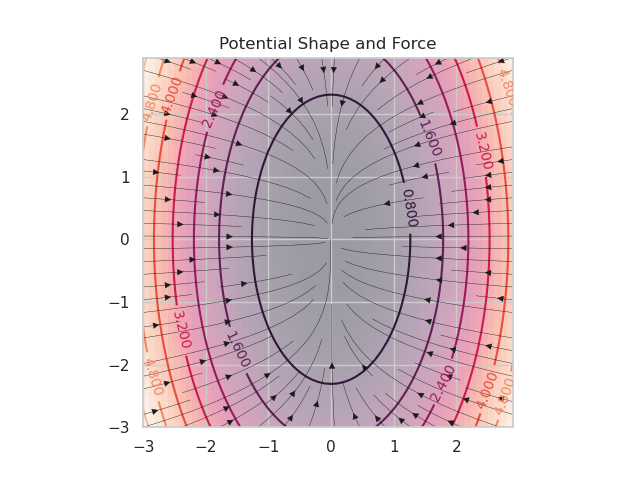

Text(0.5, 1.0, 'Potential Shape and Force')

In [15]:
x = np.arange(-3,3,0.1) 
y = np.arange(-3,3,0.1)
xx,yy = np.meshgrid(x,y)

def force(r, k):
    F = np.array([0.,0.,0.])
    F = F + [-1.*k[axis]*r[axis] for axis in range(3)]
    return F

Fx,Fy,Fz = force([xx,yy,0.], k)
V = (Fx**2)/(2*k[0]) + (Fy**2)/(2*k[1]) + (Fz**2)/(2*k[2])

subplots()
imshow(V,extent=[np.min(x),np.max(x),np.min(y),np.max(y)],origin='lower',alpha=0.4)
CS = contour(V,extent=[np.min(x),np.max(x),np.min(y),np.max(y)])
clabel(CS, CS.levels, inline=True, fontsize=10)
streamplot(xx,yy,Fx,Fy, density=[1, 1],color='k', linewidth=0.3)
title('Potential Shape and Force')

### Plotting:

<IPython.core.display.Javascript object>


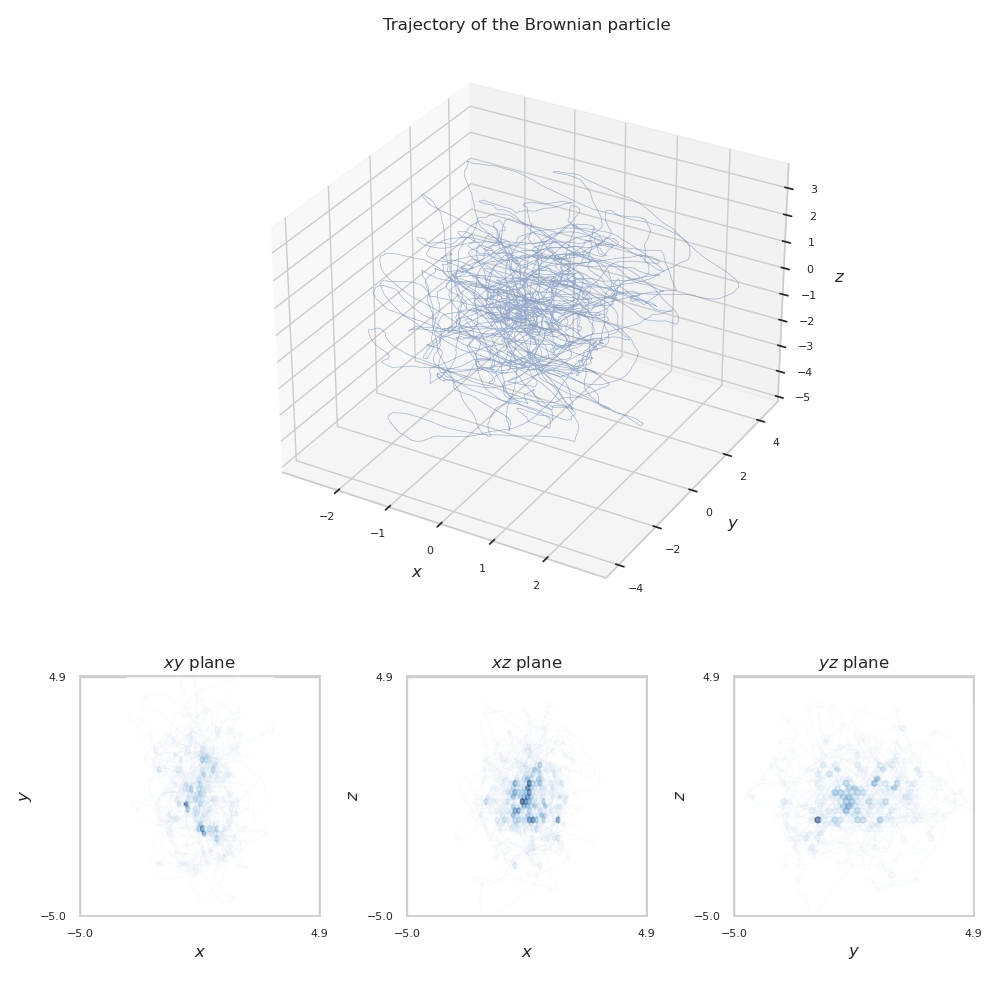

(-5.017319140851892, 3.708955388976613)

In [16]:
from scipy.stats import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

%matplotlib notebook

###########################################################################
#ignore this, just to define a colormap that goes to transparent for hexbin
cmap = cm.Blues
my_cmap = cmap(np.arange(cmap.N))
alphas = np.linspace(0, 1, cmap.N)
BG = np.asarray([1., 1., 1.,])
for i in range(cmap.N):
    my_cmap[i,:-1] = my_cmap[i,:-1] * alphas[i] + BG * (1.-alphas[i])
my_cmap = ListedColormap(my_cmap)
###########################################################################4

#####Plots#################################################################
fig = figure(figsize=(10,10))
    
gs = fig.add_gridspec(2,3,height_ratios = [2,1], width_ratios= [1,1,1])
    
rcParams.update({'font.size': 12})
rc('xtick', labelsize=8) 
rc('ytick', labelsize=8) 
    


fig.set_tight_layout(True)

plot_step = 5
x_d = data[0,:,0]
y_d = data[0,:,1]
z_d = data[0,:,2]

xmin, xmax = np.min(x_d),np.max(x_d)
ymin, ymax = np.min(y_d),np.max(y_d)
zmin, zmax = np.min(z_d),np.max(z_d)

########xy plane##############

ax = fig.add_subplot(gs[1,0])
ax.hexbin(x_d,y_d, cmap=my_cmap, gridsize=40,alpha=0.5)
#contourf(np.transpose(f), cmap = 'Blues', aspect='auto', extent = [xmin,xmax,ymin,ymax],alpha=1.,origin='lower')
ax.plot(x_d,y_d, alpha=0.2, color='b', lw=0.1)

range_min = min([xmin,ymin,zmin])
range_max = max([xmax,ymax,zmax])
ax.set_xlim([range_min,range_max])
ax.set_ylim([range_min,range_max])
ax.set_xticks([np.round(range_min,1),np.round(range_max,1)])
ax.set_yticks([np.round(range_min,1),np.round(range_max,1)])

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r"$xy$ plane")
ax.set_aspect('equal')


########xz plane##############
ax = fig.add_subplot(gs[1,1])
ax.hexbin(x_d,z_d, cmap=my_cmap, gridsize=40,alpha=0.5)
#contourf(np.transpose(f), cmap = 'Blues', aspect='auto', extent = [xmin,xmax,ymin,ymax],alpha=1.,origin='lower')
ax.plot(x_d,z_d, alpha=0.2, color='b', lw=0.1)

range_min = min([xmin,ymin,zmin])
range_max = max([xmax,ymax,zmax])
ax.set_xlim([range_min,range_max])
ax.set_ylim([range_min,range_max])
ax.set_xticks([np.round(range_min,1),np.round(range_max,1)])
ax.set_yticks([np.round(range_min,1),np.round(range_max,1)])

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$z$')
ax.set_title(r"$xz$ plane")
ax.set_aspect('equal')

########yz plane##############
ax = fig.add_subplot(gs[1,2])
ax.hexbin(y_d,z_d, cmap=my_cmap, gridsize=40,alpha=0.5)
#contourf(np.transpose(f), cmap = 'Blues', aspect='auto', extent = [xmin,xmax,ymin,ymax],alpha=1.,origin='lower')
ax.plot(y_d,z_d, alpha=0.2, color='b', lw=0.1)

range_min = min([xmin,ymin,zmin])
range_max = max([xmax,ymax,zmax])
ax.set_xlim([range_min,range_max])
ax.set_ylim([range_min,range_max])
ax.set_xticks([np.round(range_min,1),np.round(range_max,1)])
ax.set_yticks([np.round(range_min,1),np.round(range_max,1)])

ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$z$')
ax.set_title(r"$yz$ plane")
ax.set_aspect('equal')
        

##########3d Plot###############
ax = ax = fig.add_subplot(gs[0,:],projection='3d')
line = plot(x_d,y_d,z_d, lw=0.5, c='b',alpha=0.5) # For line plot
step=10

 
# AXES PROPERTIES]
# ax.set_xlim3d([limit0, limit1])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_title('Trajectory of the Brownian particle')
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.set_zlim((zmin,zmax))

#ax.set_xticks([np.round(xmin,1),np.round(xmax,1)])
#ax.set_yticks([np.round(ymin,1),np.round(ymax,1)])
#ax.set_zticks([np.round(zmin,1),np.round(zmax,1)])





### Signals Obtained:

In [17]:
#Plots of the signals [x(t),y(t),z(t)]
subplots()
subplot(311)
ax=gca()
ax.plot(time_axis, x_d, color = 'k', lw =0.5)
ax.set_xticks([])
ax.set_ylabel(r'$x$')
subplot(312)
ax=gca()
ax.plot(time_axis, y_d, color = 'k', lw =0.5)
ax.set_xticks([])
ax.set_ylabel(r'$y$')
subplot(313)
ax=gca()
ax.plot(time_axis, z_d , color = 'k', lw =0.5)
ax.set_ylabel(r'$z$')
tight_layout()

<IPython.core.display.Javascript object>

### 1. Stiffness computation using standard deviation

In [18]:
sys.path.append("Calibration/std_dev")  # add folder with calibration scripts

import std_dev as sd  # import the potential analysis script

k_estimate, k_var = sd.main(data, gama, diff)

print(k_estimate , r'$\pm$', np.sqrt(k_var))

[1.01616805 0.30313363 0.47941573] $\pm$ [0.00073809 0.01763623 0.02457333]


# 2. Stiffness computation using Power Spectral Density

In [1]:
from scipy import signal

fc = k[0]/(2*np.pi*gama)

def Lorentzian(f, fc, D):
    return D/(2. *(fc**2 + f**2)*np.pi**2)

def PSD(xdata, ydata, dt):
   
    freqs_x, PSD_x = signal.welch(xdata,1/dt, scaling = "density", nperseg=1024)
    freqs_y, PSD_y = signal.welch(ydata,1/dt, scaling = "density", nperseg=1024)
   
    return PSD_x, PSD_y, freqs_x, freqs_y

plt.figure(32)
psd_x, psd_y, freqs_x, freqs_y = PSD(data[0,:,1], data[0,:,0], delta_t)
plt.plot(freqs_y, psd_y,label="y")
plt.plot(freqs_x, psd_x,label="x")
plt.plot(np.linspace(0.,100.,1000), Lorentzian(np.linspace(0.,100.,1000),fc,diff), label="psd theoretical")
plt.plot(np.full(2,1/delta_t), np.array([0,1]))
plt.plot(np.full(2,1/T), np.array([0,1]))
plt.plot(np.full(2,k[0]/gama), np.array([0,1]))
plt.plot(np.full(2,gama/m), np.array([0,1]))

plt.xscale("log")
plt.yscale("log")
plt.legend()




print(psd_x.size)
print(psd_y.size)

NameError: name 'k' is not defined

# 3. Stiffness computation using Boltzmann Statistics

>>> Counting:
>>> Done!
>>> Determining mean density:
>>> Done!
>>> Determining density variances:
>>> Done!
(array([ 1.00134097,  0.0207245 , -0.00290925]), array([[1.76953887e-03, 2.61885479e-04, 7.52599787e-05],
       [2.61885479e-04, 1.69650612e-04, 7.99550000e-06],
       [7.52599787e-05, 7.99550000e-06, 4.36467633e-06]]))


<IPython.core.display.Javascript object>


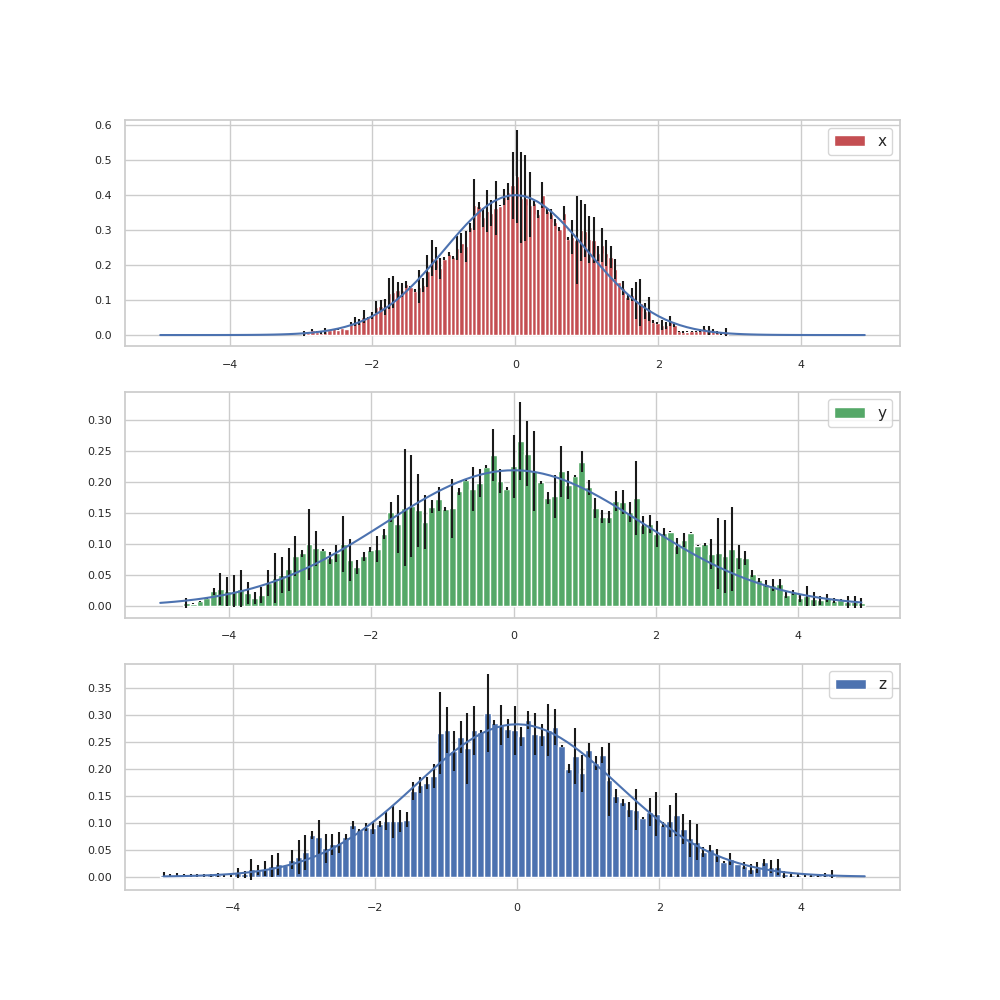

In [20]:
sys.path.append("Calibration/potential_analysis")  # add folder with calibration scripts

P = 100

import potential_analysis as pa  # import the potential analysis script
mean_density, variance, bins = pa.main(data, P, gama, diff)

import matplotlib.pyplot as plt
def normal(x, k, gama, diff):
    return np.sqrt(k/(2.*gama * diff * np.pi)) * np.exp(-k * (x**2)/(2.*gama * diff))

x_axis = np.linspace(np.min(bins),np.max(bins), 100)
y_axis = np.linspace(np.min(bins),np.max(bins), 100)
z_axis = np.linspace(np.min(bins),np.max(bins), 100)

dx_axis = x_axis[1]-x_axis[0]
dy_axis = y_axis[1]-y_axis[0]
dz_axis = z_axis[1]-z_axis[0]

fig1, (axs1, axs2, axs3) = subplots(3, figsize=(10,10))
axs1.plot(x_axis, normal(x_axis, k[0],gama,diff))
axs1.bar(bins[:, 0], mean_density[:, 0], yerr = np.sqrt(variance[:,0]), width=(bins[1,0]-bins[0,0]), label = "x", color="r")
axs1.legend()
axs2.plot(y_axis, normal(y_axis, k[1],gama,diff))
axs2.bar(bins[:, 1], mean_density[:, 1], yerr = np.sqrt(variance[:,1]), width=(bins[1,1]-bins[0,1]), label = "y", color="g")
axs2.legend()
axs3.plot(z_axis, normal(z_axis, k[2],gama,diff))
axs3.bar(bins[:, 2], mean_density[:, 2], yerr = np.sqrt(variance[:,2]), width=(bins[1,2]-bins[0,2]), label = "z", color="b")
axs3.legend()